# 04. Networks


In this exercise, we will explore networks and distance. We will start by using an abstract network of points and lines to illustrate some concepts, and then move on to using real-world data to identify proximate objects based on network distance.


## Import libraries


In [33]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [2]:
# we'll begin by borrowing the plotting helper function we created in the geoprocessing notebook for use here.
# oftentimes when writing functions that we want to come back to, we can create a new python file (such as utils.py)
# and import functions from there.
def set_axis_off():
    """
    Set the default matplotlib settings to turn off axes and ticks.
    This function modifies the global matplotlib configuration to hide axes and ticks
    for all plots created after this function is called.
    """
    # set axis off by default
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    # set tick params off by default
    plt.rcParams["xtick.bottom"] = False
    plt.rcParams["xtick.top"] = False
    plt.rcParams["xtick.labelbottom"] = False
    plt.rcParams["xtick.labeltop"] = False
    plt.rcParams["ytick.left"] = False
    plt.rcParams["ytick.right"] = False
    plt.rcParams["ytick.labelleft"] = False
    plt.rcParams["ytick.labelright"] = False

In [3]:
set_axis_off()

To begin, we will find the approximate bounding box of NYC.


In [4]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

## Create random network


We'll begin by creating a dataframe of 100 random points. As we can see below, we are using `numpy` to generate random numbers, along with geopandas' `points_from_xy()` to create a geodataframe from these points. We are using the bounds of NYC to make sure that the network approximately covers the city.


In [5]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

And here we cast the dataframe as a geodataframe and set its CRS.


In [6]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

As we can see from our initial plot, we have a mass of 100 randomly distributed points. At this stage, this is meaningless!


<Axes: >

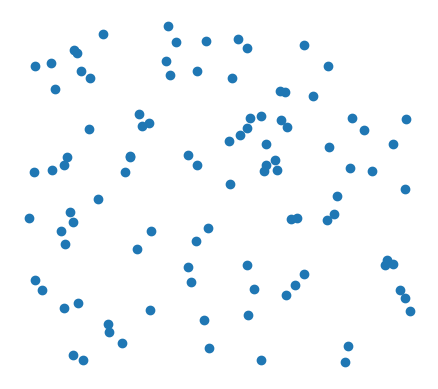

In [7]:
gdf.plot()

Since we are creating a network (instead of analyzing an already existing one), let's connect each node to its five nearest neighbors (measured based on straight-line or _Euclidean_ distance). We'll use geopandas' `distance` method to calculate the distance between each pair of points, and then use that to create a list of edges. There are many ways to calculate distance like this, some of which are more appropriate for working with a greater volume of data (`scipy`'s `KDTree` operations chief among them).

We can also ignore the warning about the geographic CRS as well given our use case and scale, but do keep in mind that projection-related considerations are extremely important when calculating distances.


In [8]:
# find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

/var/folders/zc/qdnzs1013w16v7hzj7q_j9jr0000gn/T/ipykernel_69246/2007509322.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


Now if we inspect our dataframe, we see that we have an additional column, `neighbors`, which contains the row index number of the five nearest points to that row.


In [9]:
gdf.head()

,geometry,neighbors
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]"
1,POINT (-73.87089 40.608),"[83, 91, 42, 39, 31]"
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]"
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]"
4,POINT (-74.04581 40.5995),"[29, 41, 32, 58, 80]"


Based on that information, we can now draw _lines_ (or network _edges_) between each point and its nearest neighbors. We can use the following function to create an array of lines between a point and it's neighbors.

Let's consider the component parts of the function:

- `lines = []`: we create an empty array to store line geometry in
- `for i, neighbor in enumerage(r.neighbors)`: we set up a `for` loop to iterate through each row's list of point indexes
- `lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))`: we create a new `LineString` geometry with two points: the starting point at the input row `r.geometry`, and ending at the looked up neighbor's geometry `gdf.loc[neighbor].geometry`. The `.loc[neighbor]` allows us to find the row that matches based on the neighbor `id`, and then we access its `geometry` property
- `return MultiLineString(lines)`: we combine each of the line geometries in the `lines` array into one complex `MultiLineString`, which is what it sounds like (a combination of `LineStrings`).


In [10]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

We can then apply the function to each row (`axis=1`). Keep in mind that when executing a function via `apply()`, the row (or column) input is implied and is the default input `r` in the function.


In [11]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

If we inspect our dataframe again, we'll see a new column `line_geometry` which represents the edges between each point and its five nearest neighbors.


In [12]:
gdf.head()

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.608),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.608, -73.88452 ..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.5995),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.5995, -74.0512 ..."


We can create a new geodataframe based on this edges geometry and plot it- now we have a connected network of points and lines!


In [13]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

<Axes: >

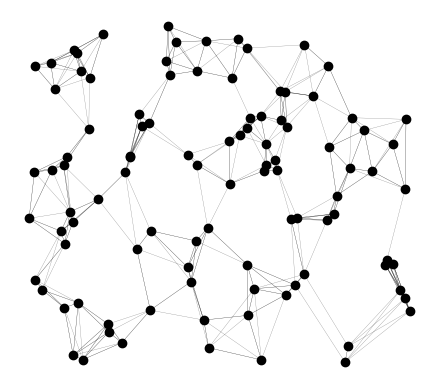

In [14]:
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black")

# optionally save the figure to file
# plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)

### Saving our datasets


You may optionally want to save these nodes and edges to file to inspect in QGIS or another software. To do so, we use the `to_file()` function to save out as GeoJSON files


In [15]:
gdf["geometry"].to_file("nodes.geojson", driver="GeoJSON")
gdf["line_geometry"].to_file("edges.geojson", driver="GeoJSON")

/opt/miniconda3/envs/cdp/lib/python3.12/site-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [16]:
gdf.sample(10)

,geometry,neighbors,line_geometry
91,POINT (-73.89955 40.58394),"[83, 1, 96, 50, 33]","MULTILINESTRING ((-73.89955 40.58394, -73.8845..."
29,POINT (-74.0512 40.61603),"[4, 41, 58, 32, 90]","MULTILINESTRING ((-74.0512 40.61603, -74.04581..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
50,POINT (-73.95788 40.55978),"[96, 73, 33, 91, 32]","MULTILINESTRING ((-73.95788 40.55978, -73.9480..."
44,POINT (-73.89994 40.82248),"[56, 62, 45, 74, 2]","MULTILINESTRING ((-73.89994 40.82248, -73.9081..."
78,POINT (-74.12232 40.78177),"[48, 94, 30, 85, 57]","MULTILINESTRING ((-74.12232 40.78177, -74.1107..."
33,POINT (-73.95894 40.61931),"[96, 50, 91, 58, 83]","MULTILINESTRING ((-73.95894 40.61931, -73.9480..."
65,POINT (-74.07876 40.84232),"[40, 9, 51, 49, 48]","MULTILINESTRING ((-74.07876 40.84232, -74.0843..."
75,POINT (-74.27649 40.58957),"[97, 69, 92, 67, 15]","MULTILINESTRING ((-74.27649 40.58957, -74.2879..."
45,POINT (-73.89762 40.78156),"[62, 37, 44, 2, 56]","MULTILINESTRING ((-73.89762 40.78156, -73.9062..."


Let's plot the nearest neighbors and connecting edges for a single point. Below, we take a random point `s` and then highlight it in blue, and connect it to its five nearest neighbors in orange. Keep in mind that every time you rerun the following cell, a new sampled point will be chosen.


<Axes: >

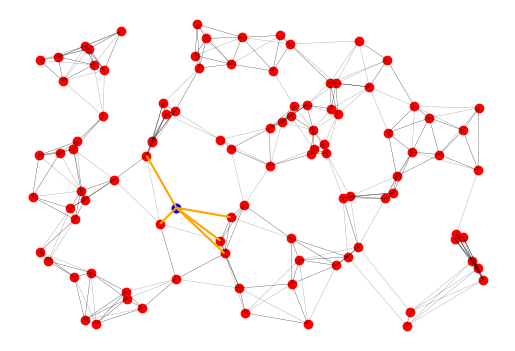

In [17]:
# plot the lines for a single point
s = gdf.sample()
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

## Apply to a real-world example


The toy problem above was a fine way to explore this concept, so now let's apply it to real-world networks. We will use an API endpoint hosted through NYCOpenData to find restaurants in Morningside Heights.

There are a couple of things to keep in mind about the following API request. First is the request itself: we use the popular `requests` library to perform a `GET` request (there are many types of requests, read more [here](https://requests.readthedocs.io/en/latest/user/quickstart/#make-a-request)) on the API endpoint listed at the resource URL.

We can see on the open data portal's website that each dataset has an `Actions` dropdown, and within that there's an `API` option:

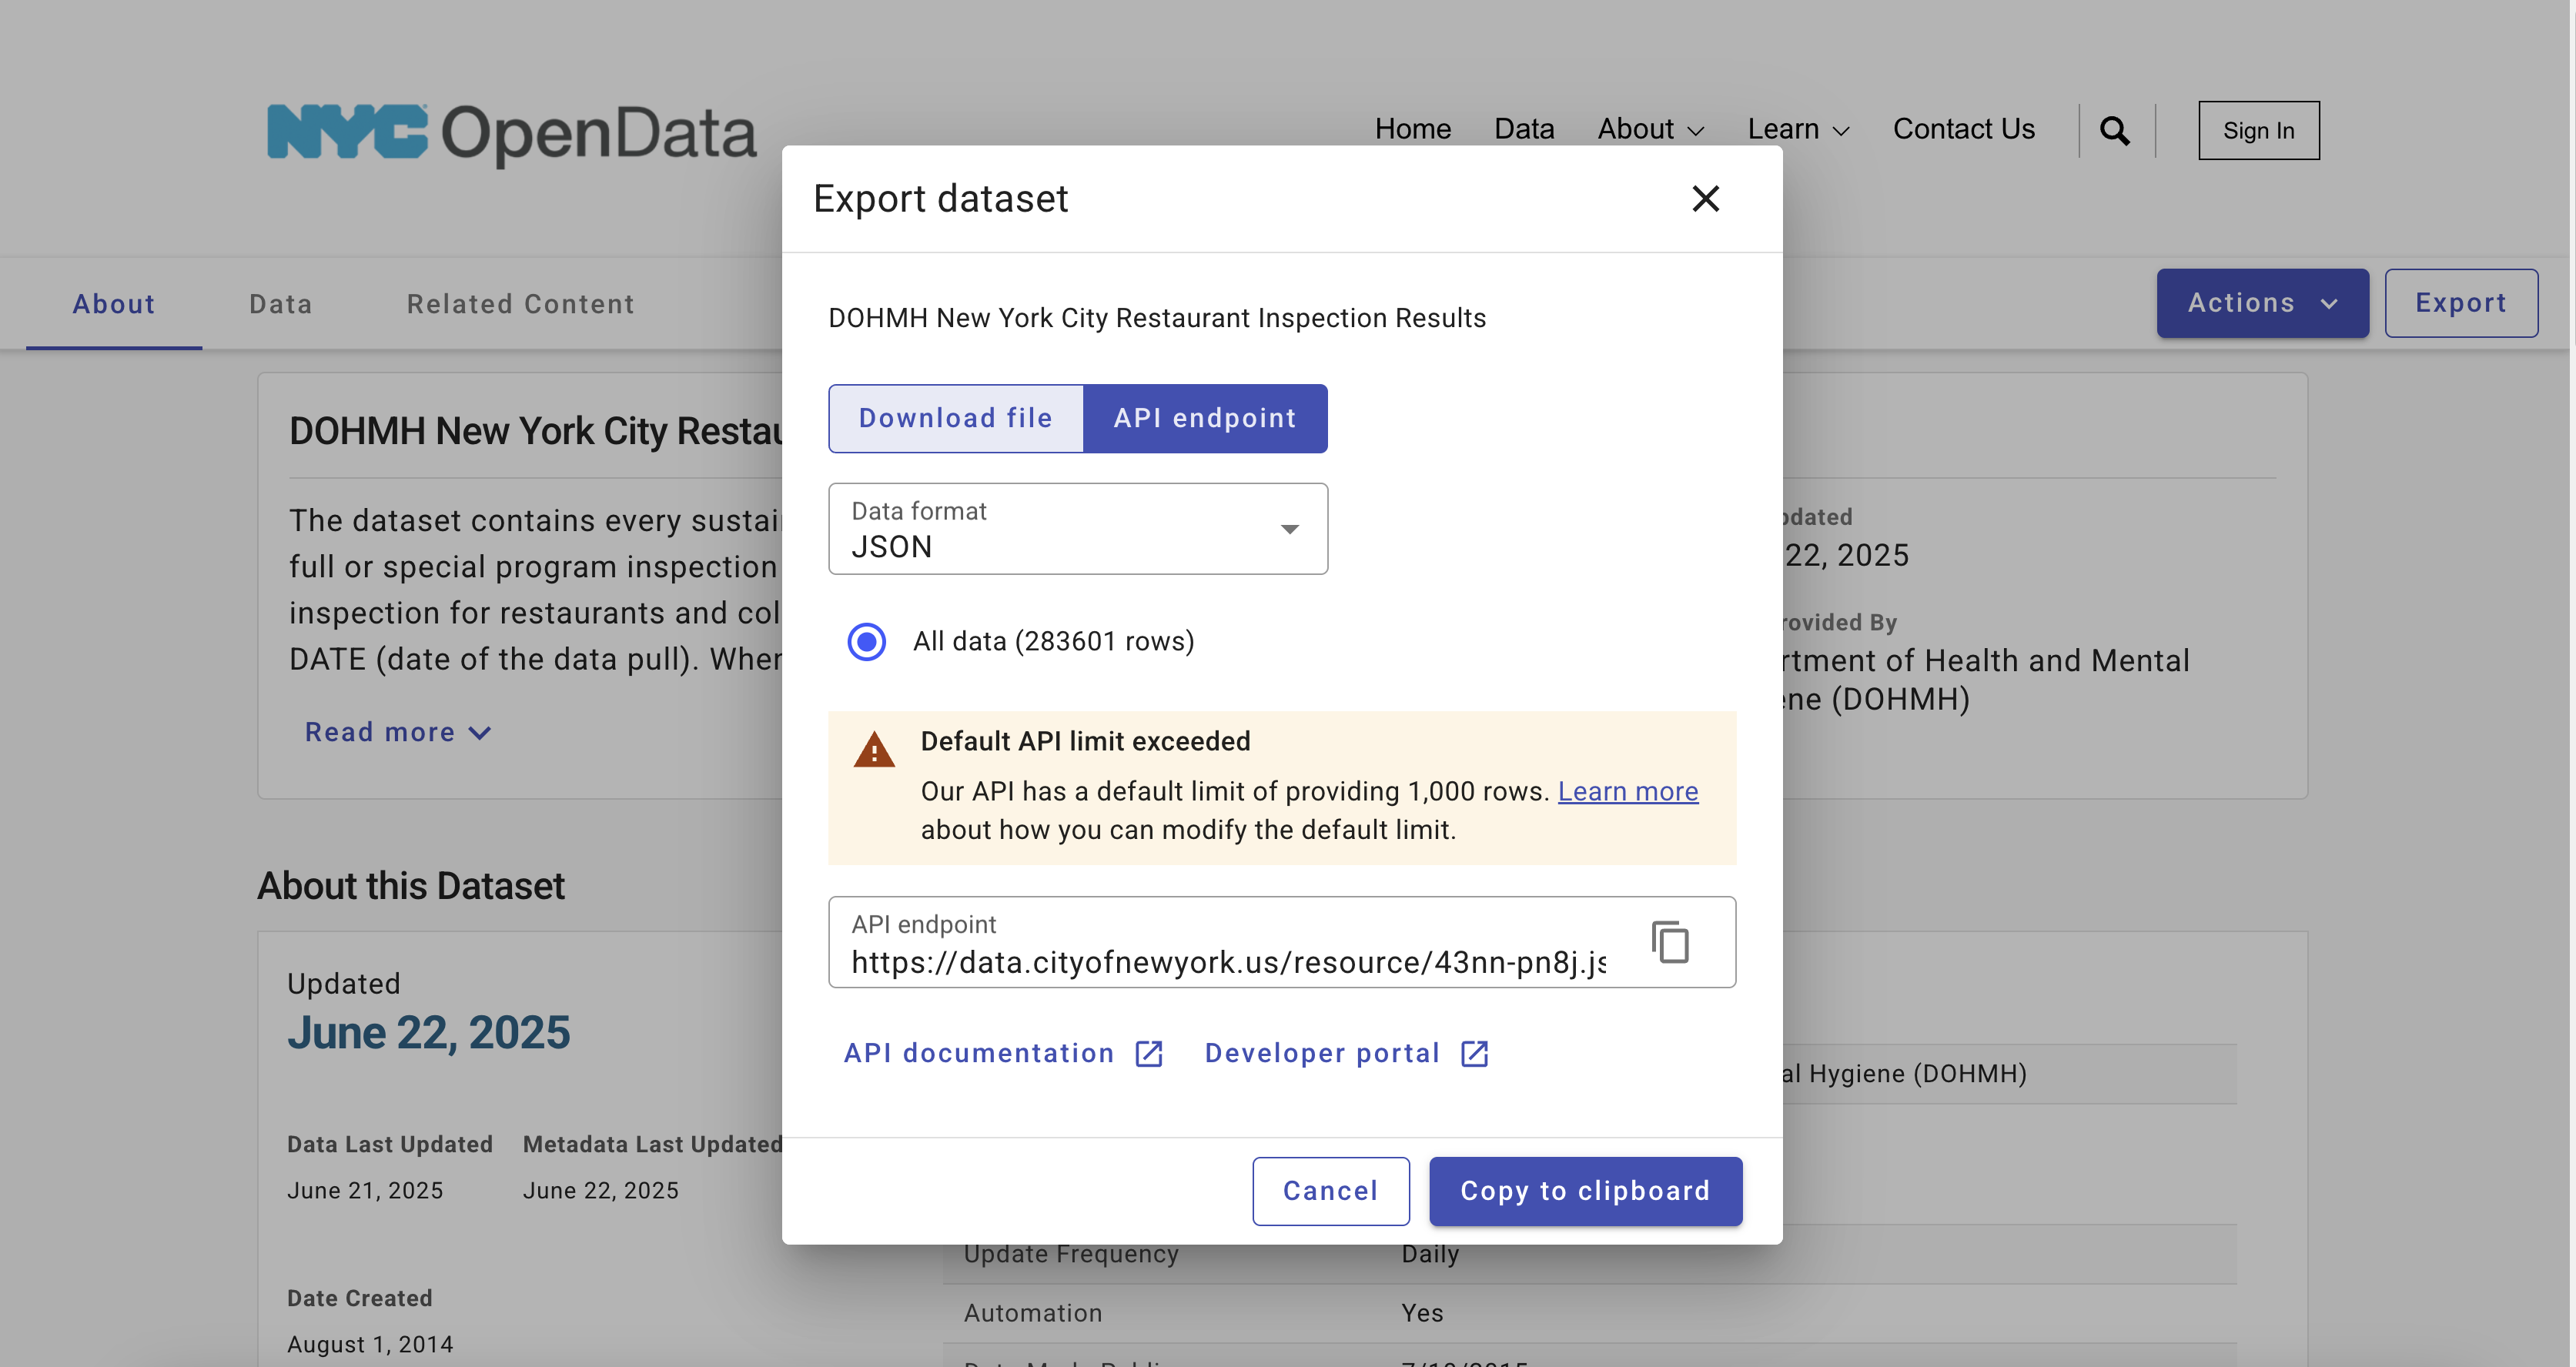

The API endpoint given there is the basis of the URL below. We are adding some additional query filters to focus the response items and reduce the total number of responses (as you can see in the screenshot above, there are over 280,000 results).

We add `?NTA=MN09&$limit=2000`, which signifies that we only want resulst where the `NTA` field equals `MN09` (i.e. Morningside Heights) and we `limit` the number of responses to `2000`. You can learn more about formatting SODA queries [here](https://dev.socrata.com/consumers/getting-started.html)


## get restaurants in Morningside Heights


If a query is successful, it will return a result that starts with `2**`, such as `200`. Error codes are reserved for `4**` and `5**`. We can make this most basic request first to confirm that our query is properly formatted:


In [18]:
requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
)

<Response [200]>

What we really want, however, is the `json` associated with the response. We can create a new variable and set it to equal the response json payload:


In [19]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

If we print the results, we see we have an array of objects (up to 2000) that represents the restaurants in `MN09`. If you scan through, you'll see attributes like street, building number, cuisine_description, and restaurant scores.


In [20]:
mh_restaurants

[{'camis': '41698701',
  'dba': 'CURRY KING',
  'boro': 'Manhattan',
  'building': '942',
  'street': 'COLUMBUS AVENUE',
  'zipcode': '10025',
  'phone': '6466697826',
  'cuisine_description': 'Pakistani',
  'inspection_date': '2025-04-28T00:00:00.000',
  'action': 'Violations were cited in the following area(s).',
  'violation_code': '02B',
  'violation_description': 'Hot TCS food item not held at or above 140 °F.',
  'critical_flag': 'Critical',
  'score': '56',
  'record_date': '2025-07-31T06:01:35.000',
  'inspection_type': 'Cycle Inspection / Initial Inspection',
  'latitude': '40.799439828364',
  'longitude': '-73.962725529944',
  'community_board': '107',
  'council_district': '07',
  'census_tract': '019300',
  'bin': '1055967',
  'bbl': '1018610030',
  'nta': 'MN09'},
 {'camis': '41271036',
  'dba': 'CHIPOTLE MEXICAN GRILL',
  'boro': 'Manhattan',
  'building': '2843',
  'street': 'BROADWAY',
  'zipcode': '10025',
  'phone': '2122221712',
  'cuisine_description': 'Tex-Mex',
  

For these to be useful to us, let's cast the array as a geodataframe:


In [21]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [22]:
mh_restaurants.fillna("na", inplace=True)

Now we can see that we have a dataframe with a number of columns, including a geometry column, that we can use to perform calculations on.


In [23]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'record_date',
       'inspection_type', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'grade',
       'grade_date', 'geometry'],
      dtype='object')

We can also drop duplicate records (based on the `camis` unique restaurant id):


In [24]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

Let's inspect the restaurant grades:


In [25]:
mh_restaurants.grade.value_counts()

grade
na    80
A     78
N      9
B      4
C      2
Z      1
Name: count, dtype: int64

Additionally, let's check out the type of food served at each restaurant:


In [26]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          27
Coffee/Tea                        22
na                                15
Chinese                           11
Pizza                              8
Mexican                            7
Italian                            7
Japanese                           6
Hamburgers                         5
Juice, Smoothies, Fruit Salads     4
Other                              4
Asian/Asian Fusion                 4
Ethiopian                          4
French                             4
Fusion                             3
Mediterranean                      3
Indian                             3
Sandwiches/Salads/Mixed Buffet     3
Frozen Desserts                    3
Tex-Mex                            2
Middle Eastern                     2
Salads                             2
Hawaiian                           2
Chicken                            2
Caribbean                          2
Donuts                             2
Bakery Products/De

## Build a graph to allow us to search


Now that we have a geodataframe of restaurants, let's create a network based on the street grid of the neighborhood. To do so, we'll use the total geographic bounds of our restaurants dataframe to request a network from the `OSMnx` module. `OSMnx` is built on top of the `Networkx` library, and makes it easy for users to access information from `OpenStreetMap` for use in network analysis.


In [27]:
mh_bbox = mh_restaurants.total_bounds

In [28]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81596727])

Like the name implies, we can build a network graph from the bbox above using the `graph_from_bbox()` function. We can specify that we are interested in a `walk` type network (i.e. pedestrian paths and sidewalks) using the `network_type` parameter (vs `driving` or `all` for example).

Note too that the order of coordinates returned from the `total_bounds` property does not match the order that `OSMnx` expects it, so we have to reorder them via the `bbox` parameter.


In [44]:
point_network = ox.graph_from_address(
    "2960 Broadway, New York, NY 10027",
    dist=1000,
    network_type="walk",
)

We can confirm that the result is a `networkx` multidirectional (`MultiDiGraph`) graph object:


In [45]:
point_network

...and we can extract the nodes and edges of that network out as geodataframes:


In [46]:
point_net_nodes, point_net_edges = ox.graph_to_gdfs(point_network)

By inspecting the results, we can see that each row is a street network segment with a number of properties, all derived from OSM data.


In [47]:
point_net_edges.head()

osmid    highway               name  oneway  \
u        v           key                                                    
42421737 10171363583 0    195743201  secondary  West 106th Street   False   
         10171363584 0    420625562    primary    Columbus Avenue   False   
         10171363585 0    420625563    primary    Columbus Avenue   False   
         10171363586 0    420625567  secondary  West 106th Street   False   
42421741 10166004078 0    196116970    primary   Amsterdam Avenue   False   

                         reversed     length lanes maxspeed  \
u        v           key                                      
42421737 10171363583 0       True  12.354476   NaN      NaN   
         10171363584 0       True  12.763257     4   25 mph   
         10171363585 0      False  11.700391     3   25 mph   
         10171363586 0       True  12.511853     2      NaN   
42421741 10166004078 0      False  12.880514     3      NaN   

                                                                   geometry  \
u        v           key                                                      
42421737 10171363583 0    LINESTRING (-73.96287 40.79924, -73.96275 40.7...   
         10171363584 0    LINESTRING (-73.96287 40.79924, -73.9628 40.79...   
         10171363585 0    LINESTRING (-73.96287 40.79924, -73.96294 40.7...   
         10171363586 0     LINESTRING (-73.96287 40.79924, -73.963 40.7993)   
42421741 10166004078 0    LINESTRING (-73.96569 40.80043, -73.96562 40.8...   

                         width access bridge junction tunnel service  
u        v           key                                              
42421737 10171363583 0     NaN    NaN    NaN      NaN    NaN     NaN  
         10171363584 0     NaN    NaN    NaN      NaN    NaN     NaN  
         10171363585 0     NaN    NaN    NaN      NaN    NaN     NaN  
         10171363586 0     NaN    NaN    NaN      NaN    NaN     NaN  
42421741 10166004078 0     NaN    NaN    NaN      NaN    NaN     NaN

We can take a look at the distribution of restaurants relative to our network by plotting both:


<Axes: >

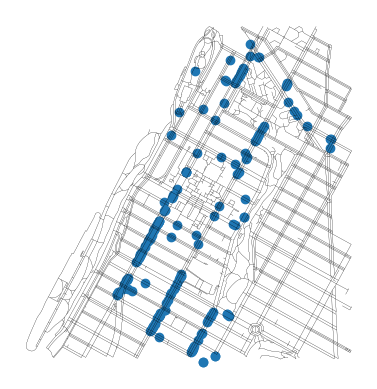

In [48]:
ax = mh_restaurants.plot()
point_net_edges.plot(ax=ax, color="black", linewidth=0.1)

Let's take a look at the output- we can see a network of nodes and edges that represent the Morningside Heights area. Note that unlike our toy example above, network edges here can have corners and curves and are not just individual line segments.


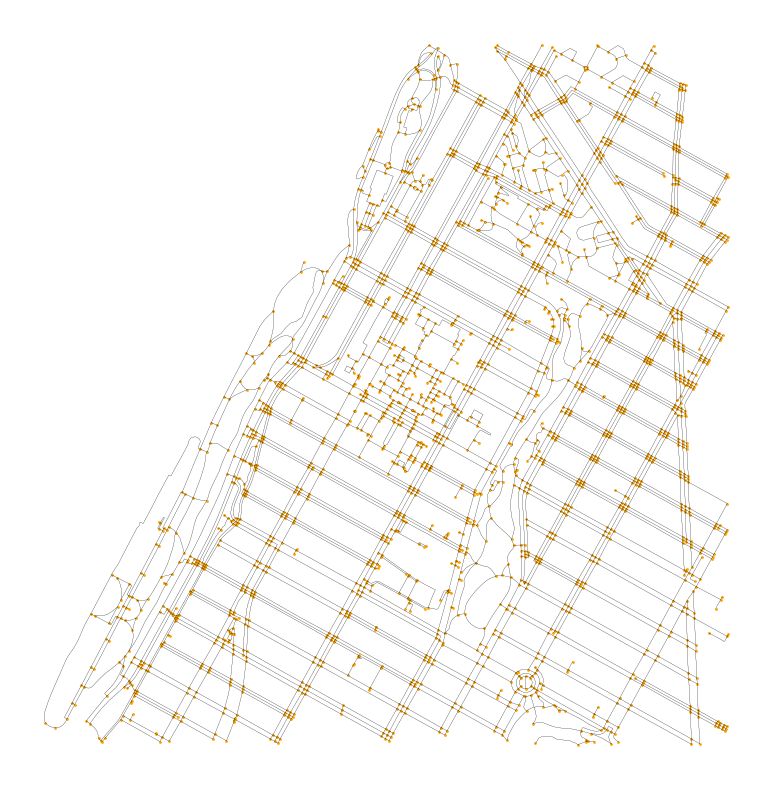

In [49]:
ax = point_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
point_net_nodes.plot(ax=ax, color="orange", markersize=1).set_axis_off()

Great - now that we have a network and locations to traverse, let's use a starting point based on where we are on campus:


In [50]:
fayerweather = Point(-73.9603477, 40.8082408)

### Get directions to a random point


First we need to associate our starting point and target points to our networks. We begin by finding the nearest network nodes between an input coordinate and the network, for both our origin and a randomly selected restaurant.


In [51]:
orig = ox.distance.nearest_nodes(point_network, fayerweather.x, fayerweather.y)
sample = mh_restaurants.sample()
dest = ox.distance.nearest_nodes(point_network, sample.geometry.x, sample.geometry.y)[0]

The above functions return the indices of the nearest network nodes:


In [52]:
orig, dest

(2340960642, np.int64(10166004078))

Now that we have _network_ positions, we can traverse the network to find the shortest path between each point. To do so, we'll use the `shortest_path()` function, and specify our `weight` as the `length` between start and end points. There are a number of options for weight, including the number of segments that need to be traversed, or a custom input you specify.

OSMnx also has special helper functions to plot routes, which we'll use to plot the network and path between points.


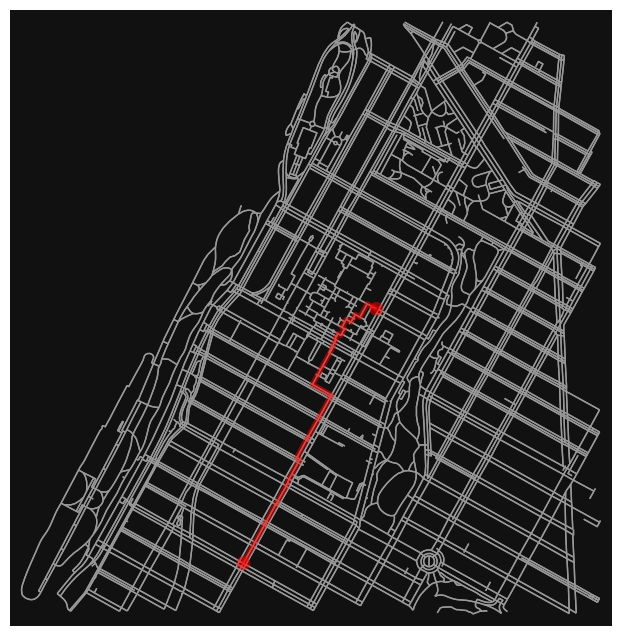

In [53]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(point_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(point_network, route, node_size=0)

If we inspect the `route` on its own, we'll see an array of node ids that are ordered based on the shortest path that is generated.


In [54]:
route

[2340960642,
 2340960647,
 2340960652,
 2340960633,
 2340960637,
 2340960632,
 2340960619,
 2340960621,
 2340960628,
 3907629293,
 2308955266,
 2308955236,
 2340960582,
 2308955275,
 2308955246,
 2308955237,
 2308955273,
 2308955255,
 2308955234,
 9484229174,
 5924124668,
 3579426865,
 627905340,
 5924124670,
 10171340197,
 10168667115,
 7326861789,
 10168667114,
 11777607957,
 7326861889,
 11777607959,
 6814307793,
 6814307795,
 6814307788,
 10170704048,
 6814307791,
 42442571,
 4717512348,
 7618358575,
 6814307785,
 42442569,
 10170893932,
 10170893924,
 42442567,
 10170893928,
 10165989507,
 42442565,
 10165989508,
 10166004026,
 10166004025,
 np.int64(10166004078)]

That's not super useful to us- thankfully OSMnx makes it easy to convert the route to a geodataframe for use elsewhere. We can also use some basic math to convert the path from meters to miles to put things in perspective.


In [55]:
edge_lengths = ox.routing.route_to_gdf(point_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.7147912767272119

# Find nearest restaurants of a given cuisine


Great, now let's hone in on a specific use case: finding the _n_ nearest restaurants of a given cuisine type based on network distances. For this example I'll search for `Pizza` but you can explore using any `cuisine_description` value you like.


In [56]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

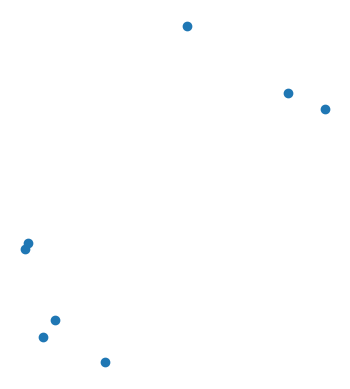

In [57]:
mh_pizza.plot()

Let's assume we are hungry and want to find the five closest pizza restaurants based on network distance. We can use the following function to do so:

- `dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)`: finds the nearest node for each input row (in this case, each pizza restaurant)
- `route = ox.shortest_path(mh_network, origin, dest, weight="length")`: finds the shortest path between each restaurant and our input point
- `edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]`: finds the total length of the route in meters
- `route_geom...`: finds and creates a unioned (combined) geometry of the route
- `return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}` returns a dictionary of distance (in miles) and the route geometry


In [60]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(point_network, row.geometry.x, row.geometry.y)
    route = ox.shortest_path(point_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(point_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(point_network, route)
    route_geom = route_geom.geometry.union_all()

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [61]:
mh_pizza.loc[:, "distance_from_class"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

If we observe our results, we can see that each row (e.g. each pizza restaurant) has a dictionary of distance in miles and the shortest path. Pretty neat, but not super ergonomic in its current form.


In [62]:
mh_pizza["distance_from_class"]

36     {'distance': 0.5182902649067782, 'route_geom':...
88     {'distance': 0.6296868617654892, 'route_geom':...
124    {'distance': 0.7147912767272119, 'route_geom':...
143    {'distance': 0.7429661601084617, 'route_geom':...
173    {'distance': 0.664326555276031, 'route_geom': ...
183    {'distance': 0.8028187334977311, 'route_geom':...
291    {'distance': 0.5765161221425937, 'route_geom':...
681    {'distance': 0.5182902649067782, 'route_geom':...
Name: distance_from_class, dtype: object

We can explode each dictionary key:value pair into a separate column using the below operation. We are combining three different steps in the below cell to achieve this:

- converting the entries in the `distance_from_class` attribute into a `pd.Series`- this is what does the separating into separate columns
- `drop`ping the `distance_from_class` field, as we no longer need it
- using the `concat(...)` function to concatenate the results of the other two operations; this allows us to combine things back together into our one dataframe


In [63]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_class"], axis=1),
        mh_pizza["distance_from_class"].apply(pd.Series),
    ],
    axis=1,
)

Now we can see we have each of the dictionary entries as new columns, and now we can operate over both in our dataframe.


In [64]:
mh_pizza.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,council_district,census_tract,bin,bbl,nta,grade,grade_date,geometry,distance,route_geom
36,50066109,KORONET PIZZA,Manhattan,2848,BROADWAY,10025,2122221566,Pizza,2024-07-11T00:00:00.000,Violations were cited in the following area(s).,...,07,019900,1056917,1018820063,MN09,na,na,POINT (-73.96641 40.80454),0.518290,"MULTILINESTRING ((-73.9602888 40.8082467, -73...."
88,40605511,DOMINO'S,Manhattan,409,WEST 125 STREET,10027,2122803200,Pizza,2024-02-26T00:00:00.000,Violations were cited in the following area(s).,...,07,020901,1059550,1019660066,MN09,na,na,POINT (-73.95451 40.81159),0.629687,"MULTILINESTRING ((-73.9602888 40.8082467, -73...."
124,41012973,MAMA'S PIZZERIA,Manhattan,941,AMSTERDAM AVENUE,10025,2125319797,Pizza,2023-04-06T00:00:00.000,Violations were cited in the following area(s).,...,07,019300,1055948,1018610001,MN09,A,2023-04-06T00:00:00.000,POINT (-73.96561 40.80055),0.714791,"MULTILINESTRING ((-73.9602888 40.8082467, -73...."
143,50131886,iPizza NY,Manhattan,351,WEST 125 STREET,10027,9172658973,Pizza,2024-09-19T00:00:00.000,Establishment Closed by DOHMH. Violations were...,...,09,020901,1059309,1019520011,MN09,na,na,POINT (-73.9528 40.81086),0.742966,"MULTILINESTRING ((-73.9602888 40.8082467, -73...."
173,50046844,DOMINO'S,Manhattan,965,AMSTERDAM AVENUE,10025,2122222000,Pizza,2022-04-05T00:00:00.000,Violations were cited in the following area(s).,...,07,019300,1055985,1018620003,MN09,na,na,POINT (-73.96507 40.80129),0.664327,"MULTILINESTRING ((-73.9602888 40.8082467, -73...."


Now let's cast our results to a new geodataframe with the `geometry` set as the routes calculated above.


In [65]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Now we can plot each pizza restaurant, the shortest path between here and there, and can symbolize based on the distance in miles:


Text(0.5, 1.0, 'Distance from Fayerweather to \n Morningside Heights Pizza Restaurants')

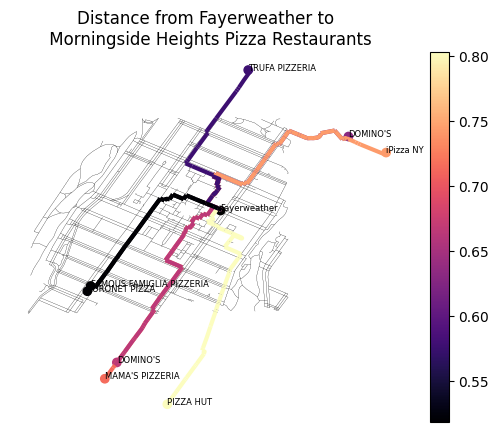

In [66]:
ax = gpd.GeoSeries(fayerweather).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each restaurant point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)

# label the fayerweather point
ax.text(fayerweather.x, fayerweather.y, "Fayerweather", fontsize=6)

# title
plt.title("Distance from Fayerweather to \n Morningside Heights Pizza Restaurants")

Great- we can now visualize and intuit the closest pizza places. If we want to look at the actual numbers, we can sort by distance and observe. Note that the top two entries are tied, which suggest that both were snapped to the same network node (which is a consideration to keep in mind when we rely on third-party datasets like OSM)


In [67]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
36,KORONET PIZZA,0.518290
681,FAMOUS FAMIGLIA PIZZERIA,0.518290
291,TRUFA PIZZERIA,0.576516
88,DOMINO'S,0.629687
173,DOMINO'S,0.664327
124,MAMA'S PIZZERIA,0.714791
143,iPizza NY,0.742966
183,PIZZA HUT,0.802819


# Use grid cells to build and traverse a network


So far, we've been able to create networks from a random distribution of points, as well as from the street network of a real-world location. For our final example, let's explore how we can use a grid of cells to create a network and traverse it. More specifically, we'll create a grid of hexagons, and then connect each hexagon to its nearest neighbors using the [h3 library](https://uber.github.io/h3-py/intro.html). H3 was developed by Uber and represents a hierarchical spatial index that uses hexagonal grid cells to partition space. Hexagons are useful for this purpose because they have a number of desirable properties, including uniform adjacency (each hexagon has six neighbors), reduced distortion compared to square grids, and efficient coverage of large areas.


In [ ]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [68]:
mh_net_nodes

74 - 76, 88 - 98

(-2, -10)

Here we are querying the H3 dataset at resolution 9 for each node in our network. You can read more about H3 resolutions [here](https://h3geo.org/docs/core-library/restable/). This will return a unique hexagon id for each point in our network. We will deduplicate these momentarily and create a new dataframe of hexagons.


In [75]:
import h3

h3.__version__

'4.3.0'

In [77]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.latlng_to_cell(x.geometry.centroid.y, x.geometry.centroid.x, 9),
    axis=1,
)

In [78]:
mh_net_nodes["h3"]

osmid
42428782       892a1008883ffff
42428790       892a1008883ffff
42428799       892a1008893ffff
42428807       892a1008893ffff
42428844       892a1008c3bffff
                    ...       
11998058281    892a1008897ffff
12005588910    892a1008c3bffff
12005588913    892a1008c2bffff
12005588914    892a1008c3bffff
12029862494    892a1008c67ffff
Name: h3, Length: 852, dtype: object

We can use the `h3_to_geo_boundary()` function to get the polygon geometry of each hexagon, and then populate a new field based on that geometry.


In [80]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(lambda x: (h3.cell_to_boundary(x)))

/var/folders/zc/qdnzs1013w16v7hzj7q_j9jr0000gn/T/ipykernel_69246/1290308739.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(lambda x: (h3.cell_to_boundary(x)))


In [81]:
mh_net_nodes["geometry"]

osmid
42428782       ((40.8051002986194, -73.96646487283995), (40.8...
42428790       ((40.8051002986194, -73.96646487283995), (40.8...
42428799       ((40.80780061538988, -73.96442683242795), (40....
42428807       ((40.80780061538988, -73.96442683242795), (40....
42428844       ((40.81320140125602, -73.96035005774733), (40....
                                     ...                        
11998058281    ((40.80521508136564, -73.96218393550407), (40....
12005588910    ((40.81320140125602, -73.96035005774733), (40....
12005588913    ((40.81050098294261, -73.96238856074181), (40....
12005588914    ((40.81320140125602, -73.96035005774733), (40....
12029862494    ((40.81038619391098, -73.96666998042426), (40....
Name: geometry, Length: 852, dtype: object

Unfortunately H3 returns the polygon vertices in the opposite order that `shapely` expects them, so we have to reverse the order of the coordinates. We can do so using a list comprehension. While we're at it, we can also cast the coordinates as a `Polygon` geometry.


In [82]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

We can assign the geometry a crs now that we know it is in lat/lon


In [83]:
mh_net_nodes.crs = "EPSG:4326"

In [84]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Finally, we'll create a new, deduplicated dataframe of hexagons.


In [85]:
h3_lvl_9_cells = mh_net_nodes.dissolve(by="h3").copy().reset_index()

<Axes: >

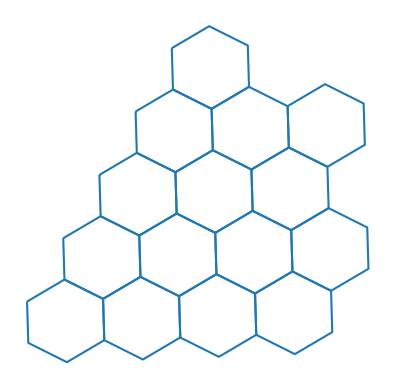

In [86]:
h3_lvl_9_cells.boundary.plot()

Great, now let's overlay the hex grid on top of our road network to get a sense of scale and how this new network compares.


<Axes: >

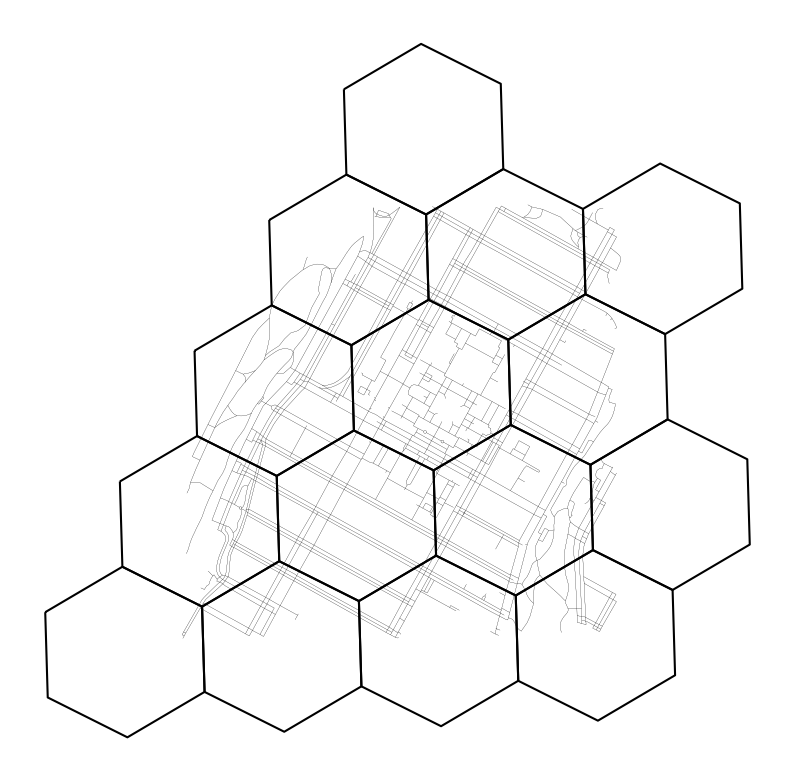

In [87]:
ax = h3_lvl_9_cells.boundary.plot(color="black", figsize=(10, 10))
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)

As we can see, the hexagons are fairly small, reasonably appropriate for the scale of our analysis (i.e. traversing city blocks). Next, we will create a network by connecting each hexagon to its six nearest neighbors. While `h3` has some native functions to calculate grid adjacency, we will use the more general purpose library `libpysal` to do so. `libpysal` is a spatial analysis library that has a number of useful functions, including the ability to calculate spatial weights and relationships between geometries.

We will caalculate a spatial weights matrix using the `Queen` contiguity method, which considers two polygons to be neighbors if they share a common edge or vertex. This is appropriate for our hexagonal grid, as each hexagon has six neighbors that share edges.


In [88]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(h3_lvl_9_cells)

/var/folders/zc/qdnzs1013w16v7hzj7q_j9jr0000gn/T/ipykernel_69246/471419787.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(h3_lvl_9_cells)


Just like with the _n_-nearest neighbors example above, we can use the spatial weights matrix to create a list of neighboring hexagons for each row in our dataframe. We can use dictionary comprehension to create a mapping of each hexagon's index to its list of neighbors, and then create a graph network from that mapping using `networkx`.


In [89]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [90]:
neighbors

{0: [1, 2, 3, 4],
 1: [0, 4],
 2: [0, 3, 4, 8, 9, 12],
 3: [0, 9, 2, 14],
 4: [0, 1, 2, 12],
 5: [11, 13],
 6: [7, 8, 9, 10, 11],
 7: [9, 6, 14],
 8: [2, 6, 9, 11, 12, 13],
 9: [2, 3, 6, 7, 8, 14],
 10: [11, 6],
 11: [5, 6, 8, 10, 13],
 12: [8, 2, 4, 13],
 13: [8, 11, 12, 5],
 14: [9, 3, 7]}

Here we create a new graph `G` based on this adjacency matrix.


In [91]:
G = nx.Graph(neighbors)

Let's take a look at the graph- each node ID is plotted on the centroid of each hexagon, and the edges represent the connections between each hexagon and its six neighbors. As before, we can ignore the geographic CRS warning for this example.


/var/folders/zc/qdnzs1013w16v7hzj7q_j9jr0000gn/T/ipykernel_69246/2249710294.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  h3_lvl_9_cells.geometry.centroid.x,
/var/folders/zc/qdnzs1013w16v7hzj7q_j9jr0000gn/T/ipykernel_69246/2249710294.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  h3_lvl_9_cells.geometry.centroid.y,


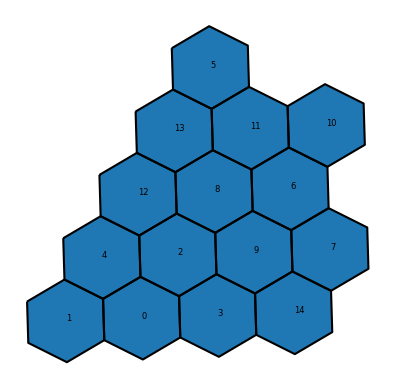

In [92]:
# plot the path
ax = h3_lvl_9_cells.plot()
h3_lvl_9_cells.boundary.plot(ax=ax, color="black")

# label cells with their index
for x, y, label in zip(
    h3_lvl_9_cells.geometry.centroid.x,
    h3_lvl_9_cells.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)

Now we can inspect the adjacency dictionary above and understand how the adjacency is structured. Each key is a hexagon index, and the value is a list of adjacent hexagon indices.

With this in mind, we can use `networkx` and the `shortest_path()` function to find the shortest path between two hexagons by passing the graph `G` and two hexagon indices. Here we are finding the shortest path between hexagon `8` and hexagon `29`.


In [96]:
# get the path between two nodes
path = nx.shortest_path(G, 1, 10)

The path is returned as a list of hexagon indices that represent the shortest path between the two input hexagons.


In [97]:
path

[1, 0, 2, 8, 6, 10]

Finally, let's visualize the path on top of the hexagon grid. We can use the `iloc[...]` function to look up the hexagons in `path` by their indices, and then plot the resulting geometries.


/var/folders/zc/qdnzs1013w16v7hzj7q_j9jr0000gn/T/ipykernel_69246/4104596610.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  h3_lvl_9_cells.geometry.centroid.x,
/var/folders/zc/qdnzs1013w16v7hzj7q_j9jr0000gn/T/ipykernel_69246/4104596610.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  h3_lvl_9_cells.geometry.centroid.y,


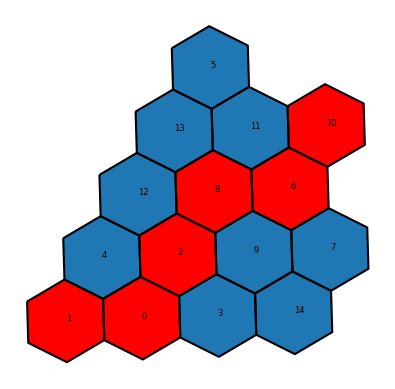

In [98]:
# plot the path
ax = h3_lvl_9_cells.plot()
h3_lvl_9_cells.boundary.plot(ax=ax, color="black")
h3_lvl_9_cells.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    h3_lvl_9_cells.geometry.centroid.x,
    h3_lvl_9_cells.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)

As we can see, the shortest path between hexagon `8` and hexagon `29` traverses through a number of intermediate hexagons, following the edges of the hexagonal grid. We can imagine cases where this type of grid-based network analysis could be useful.

One thing we didn't explore as much here is the idea of _cost_ or _weight_ associated with traversing between nodes. In our street network example above, we used the `length` of each street segment as the weight for calculating the shortest path. We could just as easily assign other weights, such as travel time, elevation change, degree of sun exposure, etc. Think about the possibilities!
